In [ ]:
import os
import io
import textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:

np.random.seed(42)

# ---------- 1) Load data (from Kaggle if present), otherwise synthesize a realistic sample ----------
possible_paths = [
    "/mnt/data/train.csv",  # typical Kaggle Titanic path if uploaded
    "/mnt/data/titanic.csv",
    "/mnt/data/Titanic.csv",
]


In [3]:
csv_path = None
for p in possible_paths:
    if os.path.exists(p):
        csv_path = p
        break



In [5]:
def synthesize_titanic(n=800):
    # Mimic distributions roughly: more males than females, more 3rd class, higher survival for females & 1st class.
    sexes = np.random.choice(["male", "female"], size=n, p=[0.64, 0.36])
    pclass = np.random.choice([1, 2, 3], size=n, p=[0.24, 0.20, 0.56])
    embarked = np.random.choice(["S", "C", "Q"], size=n, p=[0.72, 0.18, 0.10])
    age = np.clip(np.random.normal(loc=29, scale=14, size=n), 0.4, 80).round(1)
    # inject missing ages (~20%)
    age_mask = np.random.rand(n) < 0.20
    age[age_mask] = np.nan
    sibsp = np.random.poisson(lam=0.5, size=n)
    parch = np.random.poisson(lam=0.4, size=n)
    fare = np.clip(np.random.lognormal(mean=3.2 - (pclass-1)*0.55, sigma=0.6, size=n), 3, 520).round(2)

    # Survival probability influenced by sex, class, age (children), and embarkation slightly
    base = -1.0 + (sexes == "female")*1.6 + (pclass == 1)*0.8 + (pclass == 2)*0.25 + (age < 14)*0.35 + (embarked == "C")*0.1
    prob_surv = 1/(1+np.exp(-base))
    survived = (np.random.rand(n) < prob_surv).astype(int)

    df = pd.DataFrame({
        "Survived": survived,
        "Pclass": pclass,
        "Sex": sexes,
        "Age": age,
        "SibSp": sibsp,
        "Parch": parch,
        "Fare": fare,
        "Embarked": embarked,
    })
    # Add PassengerId to mimic Kaggle schema
    df.insert(0, "PassengerId", np.arange(1, n+1))
    return df

if csv_path is None:
    # Create a synthetic dataset to let the analysis run immediately.
    df = synthesize_titanic(900)
    source_note = "Synthetic Titanic-like dataset was generated because no CSV was found in /mnt/data."
else:
    df = pd.read_csv(csv_path)
    source_note = f"Loaded dataset from {csv_path}."
    # Standardize column names to Kaggle names if present
    # (Some Kaggle versions include columns like Cabin, Ticket, Name which we'll ignore for core EDA.)
    # Ensure Embarked code is consistent (str)
    if "Embarked" in df.columns:
        df["Embarked"] = df["Embarked"].astype(str)

In [6]:
# Keep only relevant columns if available
wanted = [c for c in ["PassengerId","Survived","Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"] if c in df.columns]
df = df[wanted].copy()


In [8]:
# ---------- 2) Quick overview ----------
summary_text = io.StringIO()
summary_text.write("# Titanic EDA Summary\n\n")
summary_text.write(f"- {source_note}\n")
summary_text.write(f"- Rows: {len(df)}, Columns: {len(df.columns)}\n\n")
summary_text.write("## Columns used\n\n")
summary_text.write(", ".join(df.columns) + "\n\n")
df.head(15)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,2,male,NaN,0,1,4.66,S
1,2,1,3,female,35.2,0,0,5.75,S
2,3,1,3,male,NaN,0,1,19.16,S
3,4,1,3,male,26.9,0,0,3.36,S
4,5,0,3,male,40.3,0,0,13.11,C
5,6,0,2,male,46.3,0,0,23.99,S
6,7,1,1,male,7.6,1,1,106.88,S
7,8,1,3,male,20.6,1,1,15.23,Q
8,9,1,3,female,40.5,1,0,14.48,S
9,10,0,3,male,22.5,1,0,10.18,S


In [9]:
# ---------- 3) Missing values ----------
missing = df.isna().sum().to_frame("missing_count")
missing["missing_pct"] = (missing["missing_count"]/len(df)*100).round(2)

print("Missing values per column")
missing.reset_index().rename(columns={"index": "column"})

Missing values per column


,column,missing_count,missing_pct
0,PassengerId,0,0.00
1,Survived,0,0.00
2,Pclass,0,0.00
3,Sex,0,0.00
4,Age,183,20.33
5,SibSp,0,0.00
6,Parch,0,0.00
7,Fare,0,0.00
8,Embarked,0,0.00


In [10]:
# ---------- 4) Basic cleaning: fill missing Age with median (as hinted) ----------
age_median = df["Age"].median(skipna=True) if "Age" in df.columns else None
if "Age" in df.columns:
    df["Age"] = df["Age"].fillna(age_median)

In [11]:
# Fill Embarked unknowns with mode if any
if "Embarked" in df.columns:
    embarked_mode = df.loc[df["Embarked"].notna(), "Embarked"].mode()
    if not embarked_mode.empty:
        df["Embarked"] = df["Embarked"].replace({"nan": np.nan})
        df["Embarked"] = df["Embarked"].fillna(embarked_mode.iloc[0])

In [15]:
# Create helper features
if all(col in df.columns for col in ["SibSp","Parch"]):
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

# Save cleaned dataset
clean_path = "titanic_clean.csv"
df.to_csv(clean_path, index=False)

In [16]:
# ---------- 5) Descriptive statistics ----------
desc = df.describe(include="all").transpose()

print("Descriptive statistics")
desc.reset_index().rename(columns={"index": "column"})

Descriptive statistics


,column,count,unique,top,freq,mean,std,min,25%,50%,75%,max
0,PassengerId,900.0,NaN,NaN,NaN,450.5,259.951919,1.0,225.75,450.5,675.25,900.0
1,Survived,900.0,NaN,NaN,NaN,0.416667,0.493281,0.0,0.0,0.0,1.0,1.0
2,Pclass,900.0,NaN,NaN,NaN,2.375556,0.816312,1.0,2.0,3.0,3.0,3.0
3,Sex,900,2,male,596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Age,900.0,NaN,NaN,NaN,29.105111,11.501427,0.4,22.575,29.5,35.45,69.8
5,SibSp,900.0,NaN,NaN,NaN,0.506667,0.722251,0.0,0.0,0.0,1.0,4.0
6,Parch,900.0,NaN,NaN,NaN,0.39,0.627609,0.0,0.0,0.0,1.0,4.0
7,Fare,900.0,NaN,NaN,NaN,16.140922,15.854146,3.0,7.235,11.635,18.935,145.09
8,Embarked,900,3,S,634,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,FamilySize,900.0,NaN,NaN,NaN,1.896667,0.968578,1.0,1.0,2.0,2.0,7.0


In [17]:
# ---------- 6) Groupby survival (as hinted) ----------
if "Survived" in df.columns:
    # Mean of numeric columns grouped by survival
    gb_mean = df.groupby("Survived").mean(numeric_only=True)
    print("Groupby Survived: numeric means")
    display(gb_mean.reset_index())   # Jupyter automatically shows it

    # Survival rate by categories
    def rate_by(col):
        if col in df.columns:
            tmp = df.groupby(col)["Survived"].mean().sort_values(ascending=False) * 100
            return tmp.round(2).to_frame("survival_rate_%")
        return None

    rate_tables = {}
    for c in ["Sex", "Pclass", "Embarked", "IsAlone"]:
        if c in df.columns:
            rate_tables[c] = rate_by(c)
            if rate_tables[c] is not None:
                print(f"Survival rate by {c}")
                display(rate_tables[c].reset_index())


Groupby Survived: numeric means


,Survived,PassengerId,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone
0,0,449.946667,2.468571,29.286286,0.539048,0.392381,15.242019,1.931429,0.398095
1,1,451.274667,2.245333,28.851467,0.461333,0.386667,17.399387,1.848000,0.424000


Survival rate by Sex


,Sex,survival_rate_%
0,female,66.45
1,male,29.03


Survival rate by Pclass


,Pclass,survival_rate_%
0,1,56.70
1,3,37.97
2,2,36.21


Survival rate by Embarked


,Embarked,survival_rate_%
0,Q,44.44
1,C,41.92
2,S,41.17


Survival rate by IsAlone


,IsAlone,survival_rate_%
0,1,43.21
1,0,40.60


In [18]:
# ---------- 7) VISUALIZATIONS (each chart in its own figure; no seaborn; no custom colors) ----------

def finalize_axes(ax, title, xlabel="", ylabel=""):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", alpha=0.4)

In [19]:
# Helper to avoid overlapping labels
plt.rcParams.update({"figure.autolayout": True})

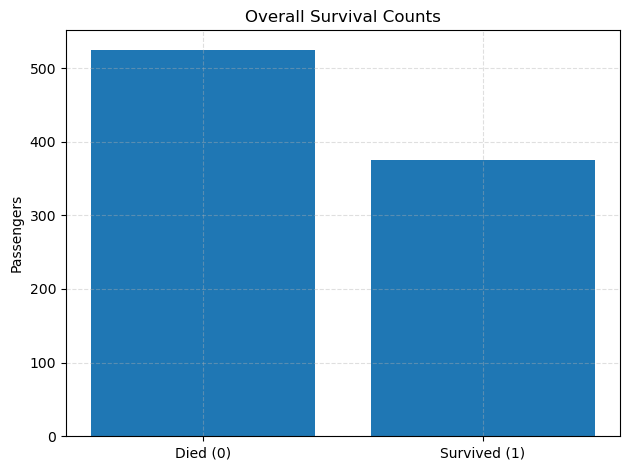

In [20]:
# 7.1 Overall survival rate (bar)
if "Survived" in df.columns:
    fig1 = plt.figure()
    ax1 = fig1.gca()
    counts = df["Survived"].value_counts().sort_index()
    ax1.bar(["Died (0)","Survived (1)"], counts.values)
    finalize_axes(ax1, "Overall Survival Counts", "", "Passengers")
    plt.show()

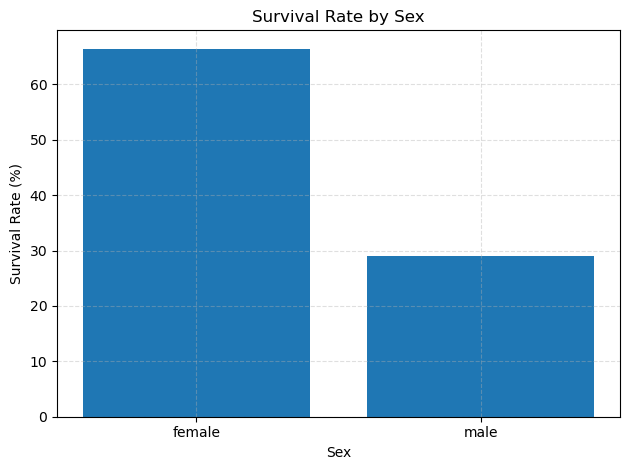

In [21]:
# 7.2 Survival rate by Sex (bar)
if all(c in df.columns for c in ["Survived","Sex"]):
    fig2 = plt.figure()
    ax2 = fig2.gca()
    sex_rate = df.groupby("Sex")["Survived"].mean()*100
    ax2.bar(sex_rate.index.astype(str), sex_rate.values)
    finalize_axes(ax2, "Survival Rate by Sex", "Sex", "Survival Rate (%)")
    plt.show()

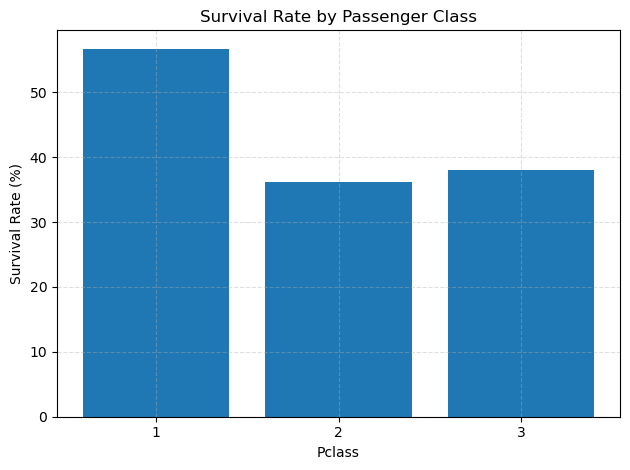

In [22]:
# 7.3 Survival rate by Pclass (bar)
if all(c in df.columns for c in ["Survived","Pclass"]):
    fig3 = plt.figure()
    ax3 = fig3.gca()
    cls_rate = df.groupby("Pclass")["Survived"].mean()*100
    ax3.bar(cls_rate.index.astype(str), cls_rate.values)
    finalize_axes(ax3, "Survival Rate by Passenger Class", "Pclass", "Survival Rate (%)")
    plt.show()


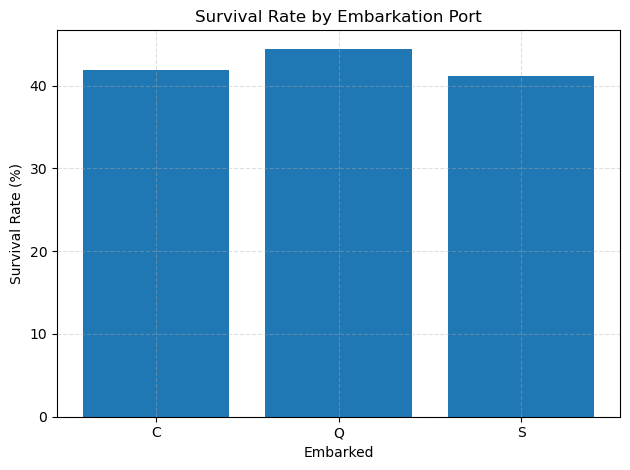

In [23]:
# 7.4 Survival rate by Embarked (bar)
if all(c in df.columns for c in ["Survived","Embarked"]):
    fig4 = plt.figure()
    ax4 = fig4.gca()
    emb_rate = df.groupby("Embarked")["Survived"].mean()*100
    ax4.bar(emb_rate.index.astype(str), emb_rate.values)
    finalize_axes(ax4, "Survival Rate by Embarkation Port", "Embarked", "Survival Rate (%)")
    plt.show()

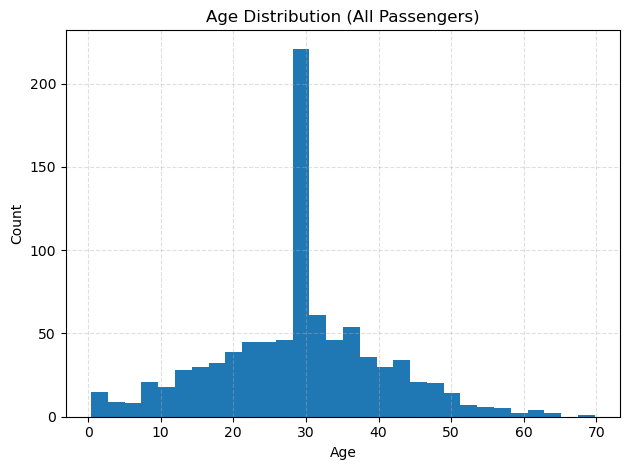

In [24]:
# 7.5 Age distribution (hist) overall
if "Age" in df.columns:
    fig5 = plt.figure()
    ax5 = fig5.gca()
    ax5.hist(df["Age"].dropna(), bins=30)
    finalize_axes(ax5, "Age Distribution (All Passengers)", "Age", "Count")
    plt.show()

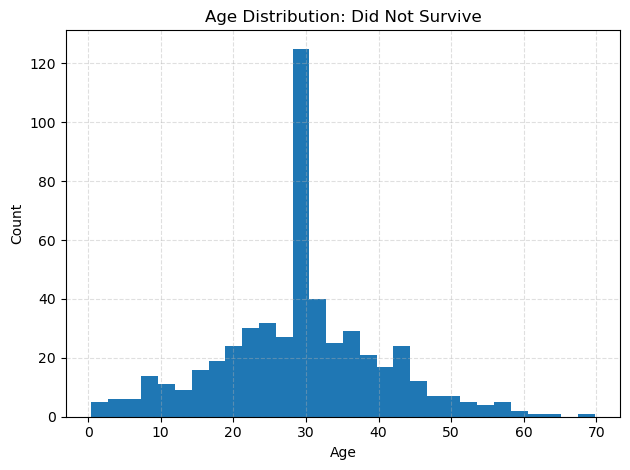

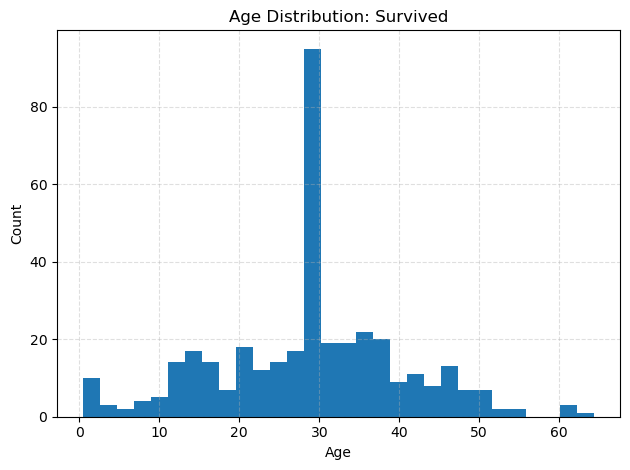

In [25]:
# 7.6 Age distribution by Survived (hist overlays using separate figures per requirement: no subplots)
if all(c in df.columns for c in ["Age","Survived"]):
    # Died
    fig6a = plt.figure()
    ax6a = fig6a.gca()
    ax6a.hist(df.loc[df["Survived"]==0, "Age"].dropna(), bins=30)
    finalize_axes(ax6a, "Age Distribution: Did Not Survive", "Age", "Count")
    plt.show()

    # Survived
    fig6b = plt.figure()
    ax6b = fig6b.gca()
    ax6b.hist(df.loc[df["Survived"]==1, "Age"].dropna(), bins=30)
    finalize_axes(ax6b, "Age Distribution: Survived", "Age", "Count")
    plt.show()


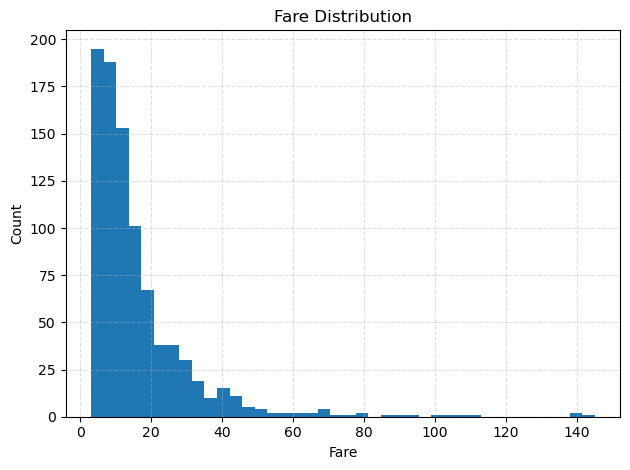

In [26]:
# 7.7 Fare distribution (hist)
if "Fare" in df.columns:
    fig7 = plt.figure()
    ax7 = fig7.gca()
    ax7.hist(df["Fare"].dropna(), bins=40)
    finalize_axes(ax7, "Fare Distribution", "Fare", "Count")
    plt.show()

/var/folders/m2/xd5v2lf911315vs2981sd8j40000gn/T/ipykernel_1099/193495926.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax8.boxplot(data, labels=[str(k) for k in sorted(df["Pclass"].dropna().unique())], showfliers=False)


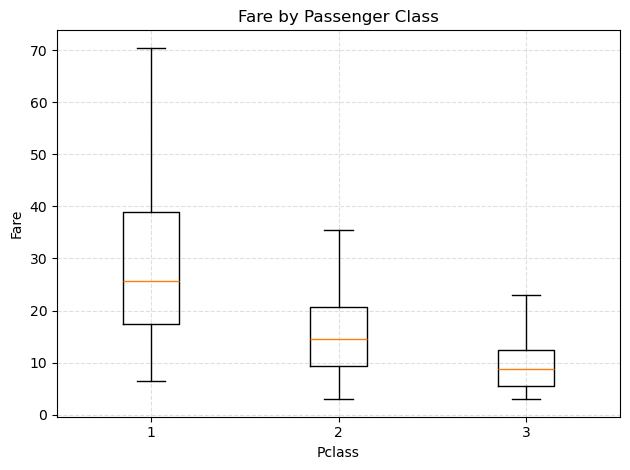

In [27]:
# 7.8 Boxplots: Fare by Pclass
if all(c in df.columns for c in ["Fare","Pclass"]):
    fig8 = plt.figure()
    ax8 = fig8.gca()
    data = [df.loc[df["Pclass"]==k, "Fare"].dropna().values for k in sorted(df["Pclass"].dropna().unique())]
    ax8.boxplot(data, labels=[str(k) for k in sorted(df["Pclass"].dropna().unique())], showfliers=False)
    finalize_axes(ax8, "Fare by Passenger Class", "Pclass", "Fare")
    plt.show()


/var/folders/m2/xd5v2lf911315vs2981sd8j40000gn/T/ipykernel_1099/749636548.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax9.boxplot(data, labels=["Died (0)", "Survived (1)"], showfliers=False)


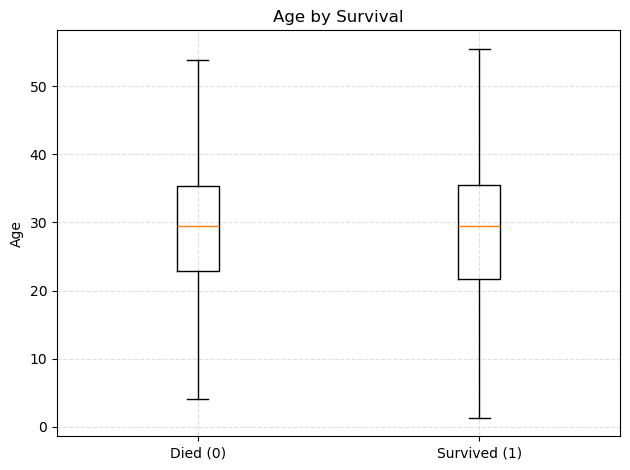

In [28]:
# 7.9 Boxplots: Age by Survived
if all(c in df.columns for c in ["Age","Survived"]):
    fig9 = plt.figure()
    ax9 = fig9.gca()
    data = [df.loc[df["Survived"]==k, "Age"].dropna().values for k in [0,1]]
    ax9.boxplot(data, labels=["Died (0)", "Survived (1)"], showfliers=False)
    finalize_axes(ax9, "Age by Survival", "", "Age")
    plt.show()

/var/folders/m2/xd5v2lf911315vs2981sd8j40000gn/T/ipykernel_1099/497333982.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax10.boxplot(data, labels=["Died (0)", "Survived (1)"], showfliers=False)


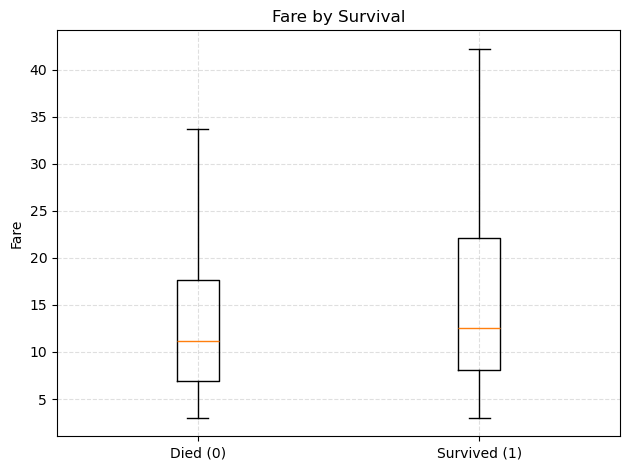

In [29]:
# 7.10 Boxplots: Fare by Survival
if all(c in df.columns for c in ["Fare","Survived"]):
    fig10 = plt.figure()
    ax10 = fig10.gca()
    data = [df.loc[df["Survived"]==k, "Fare"].dropna().values for k in [0,1]]
    ax10.boxplot(data, labels=["Died (0)", "Survived (1)"], showfliers=False)
    finalize_axes(ax10, "Fare by Survival", "", "Fare")
    plt.show()

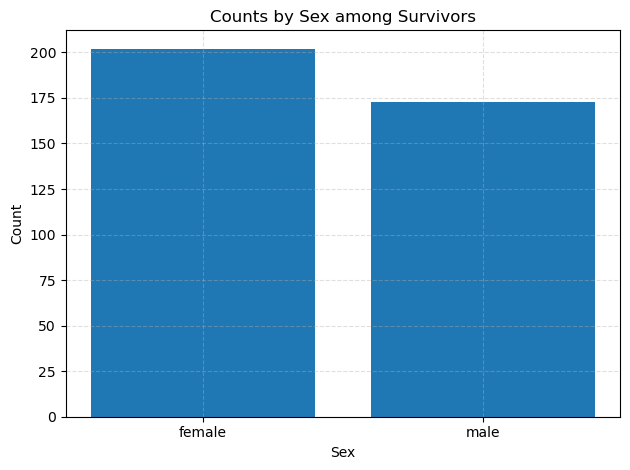

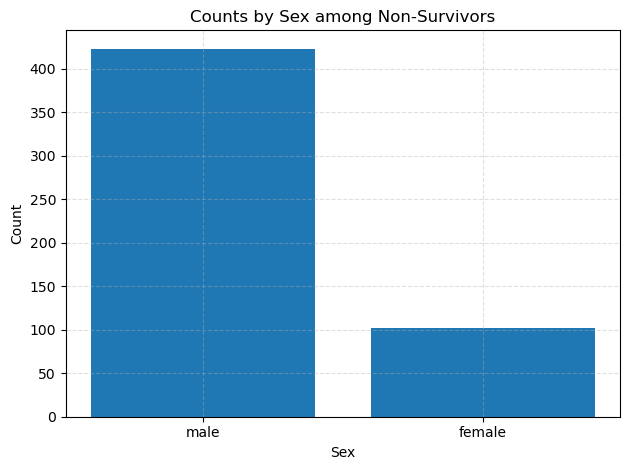

In [30]:
# 7.11 Stacked-like bars using counts: Sex within Survived (shown as two separate charts per rule)
if all(c in df.columns for c in ["Survived","Sex"]):
    # Counts by Sex among survivors
    fig11a = plt.figure()
    ax11a = fig11a.gca()
    surv_counts = df.loc[df["Survived"]==1, "Sex"].value_counts()
    ax11a.bar(surv_counts.index.astype(str), surv_counts.values)
    finalize_axes(ax11a, "Counts by Sex among Survivors", "Sex", "Count")
    plt.show()

    # Counts by Sex among non-survivors
    fig11b = plt.figure()
    ax11b = fig11b.gca()
    nons_counts = df.loc[df["Survived"]==0, "Sex"].value_counts()
    ax11b.bar(nons_counts.index.astype(str), nons_counts.values)
    finalize_axes(ax11b, "Counts by Sex among Non-Survivors", "Sex", "Count")
    plt.show()

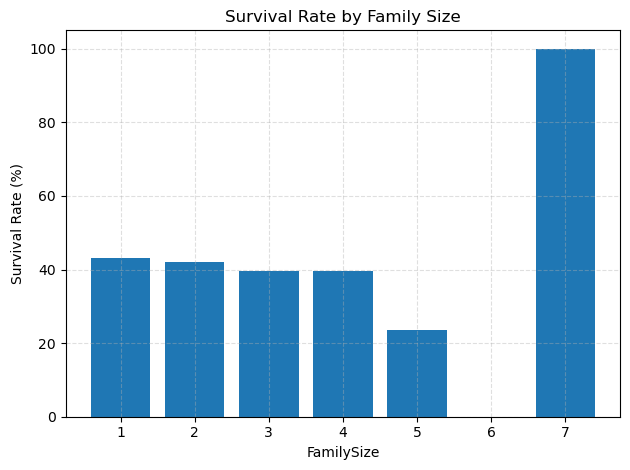

In [31]:
# 7.12 Survival rate by FamilySize (bar) if created
if all(c in df.columns for c in ["FamilySize","Survived"]):
    fig12 = plt.figure()
    ax12 = fig12.gca()
    tmp = df.groupby("FamilySize")["Survived"].mean()*100
    ax12.bar(tmp.index.astype(str), tmp.values)
    finalize_axes(ax12, "Survival Rate by Family Size", "FamilySize", "Survival Rate (%)")
    plt.show()


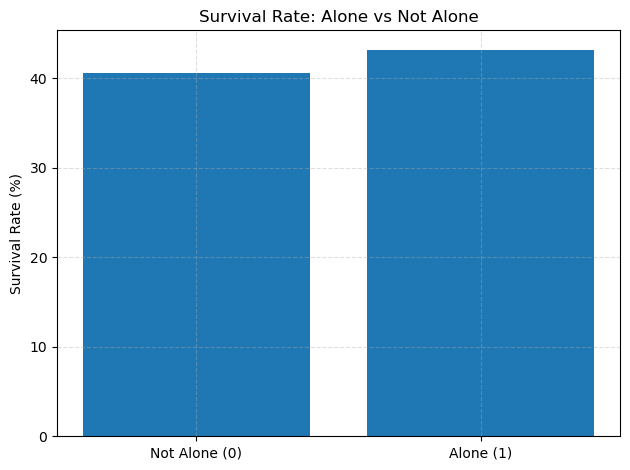

In [32]:
# 7.13 Survival rate by IsAlone (bar)
if "IsAlone" in df.columns and "Survived" in df.columns:
    fig13 = plt.figure()
    ax13 = fig13.gca()
    tmp = df.groupby("IsAlone")["Survived"].mean()*100
    ax13.bar(["Not Alone (0)", "Alone (1)"], tmp.values if 0 in tmp.index and 1 in tmp.index else tmp.values)
    finalize_axes(ax13, "Survival Rate: Alone vs Not Alone", "", "Survival Rate (%)")
    plt.show()

In [34]:
# ---------- 8) Textual insights ----------
insights = []

if "Survived" in df.columns and "Sex" in df.columns:
    sex_rate = (df.groupby("Sex")["Survived"].mean()*100).sort_values(ascending=False).round(2)
    insights.append(f"- Survival by sex (highest first): {sex_rate.to_dict()}")

if "Pclass" in df.columns and "Survived" in df.columns:
    cls_rate = (df.groupby("Pclass")["Survived"].mean()*100).sort_index().round(2)
    insights.append(f"- Survival by class (1→3): {cls_rate.to_dict()}")

if "Embarked" in df.columns and "Survived" in df.columns:
    emb_rate = (df.groupby("Embarked")["Survived"].mean()*100).round(2)
    insights.append(f"- Survival by embarkation: {emb_rate.to_dict()}")

if "Age" in df.columns and "Survived" in df.columns:
    mean_age_surv = df.groupby("Survived")["Age"].mean().round(1).to_dict()
    insights.append(f"- Mean age (by survival): {mean_age_surv}")

if "Fare" in df.columns and "Survived" in df.columns:
    mean_fare_surv = df.groupby("Survived")["Fare"].mean().round(2).to_dict()
    insights.append(f"- Mean fare (by survival): {mean_fare_surv}")

if "FamilySize" in df.columns and "Survived" in df.columns:
    fs_tmp = (df.groupby("FamilySize")["Survived"].mean()*100).round(1).to_dict()
    insights.append(f"- Survival by family size: {fs_tmp}")

summary_text.write("## Key Insights (quick bullets)\n\n")
summary_text.write("\n".join(insights) if insights else "No insights computed.\n")
summary_text.write("\n\n")

# Save textual summary
summary_path = "titanic_eda_summary.md"
with open(summary_path, "w", encoding="utf-8") as f:
    f.write(summary_text.getvalue())


In [36]:
# Also save tidy survival rates tables if present
tables_saved = []
for name, tbl in [("survival_by_sex.csv","Sex"), ("survival_by_pclass.csv","Pclass"), ("survival_by_embarked.csv","Embarked")]:
    if "Survived" in df.columns and tbl in df.columns:
        out_df = (df.groupby(tbl)["Survived"].mean()*100).round(2).reset_index().rename(columns={"Survived":"survival_rate_%"})
        out_path = f"{name}"
        out_df.to_csv(out_path, index=False)
        tables_saved.append(out_path)

In [37]:
# Final outputs
{
    "clean_csv": clean_path,
    "summary_md": summary_path,
    "extra_tables": tables_saved,
    "note": source_note
}

{'clean_csv': 'titanic_clean.csv',
 'summary_md': 'titanic_eda_summary.md',
 'extra_tables': ['survival_by_sex.csv',
  'survival_by_pclass.csv',
  'survival_by_embarked.csv'],
 'note': 'Synthetic Titanic-like dataset was generated because no CSV was found in /mnt/data.'}